In [31]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [32]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [33]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [34]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [35]:
inspector = inspect(engine)
table_names = inspector.get_table_names()
print(table_names)

['measurement', 'station']


In [36]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [37]:
# View all of the classes that automap found
for table_name in Base.classes.keys():
    print(table_name)

measurement
station


In [38]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(latest_date[0], "%Y-%m-%d").date()
print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23


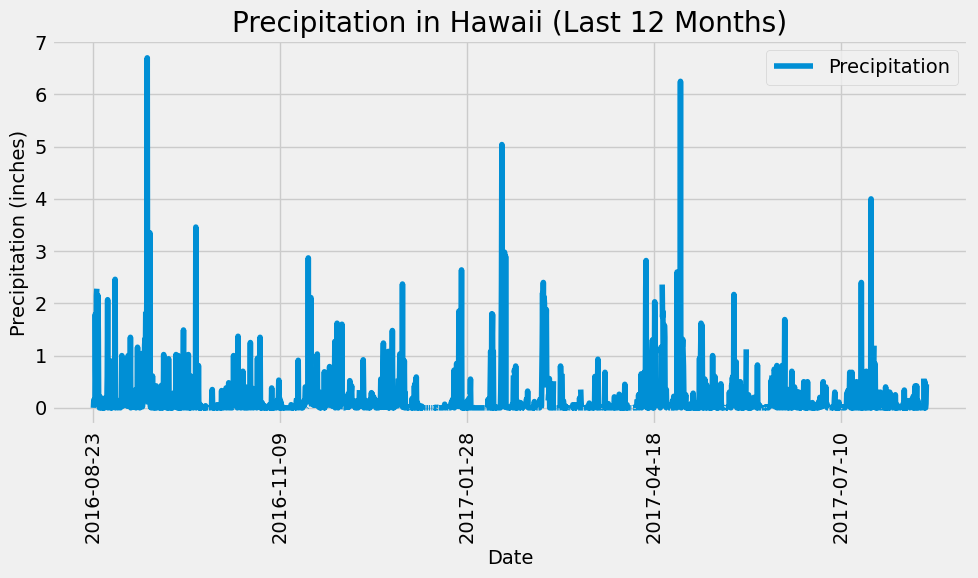

In [41]:
one_year_ago = most_recent_date - dt.timedelta(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date', inplace=True)
precipitation_df.sort_index(inplace=True)
precipitation_df.plot(figsize=(10, 6), rot=90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.tight_layout()
plt.show()


In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df.describe()
print(summary_stats)

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print("Total number of stations:", station_count)

Total number of stations: 9


In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print("Most Active Stations:")
for station, count in most_active_stations:
    print(f"Station: {station}, Observation Count: {count}")

Most Active Stations:
Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).first()
lowest_temp = temperature_stats[0]
highest_temp = temperature_stats[1]
avg_temp = temperature_stats[2]
print("Temperature Statistics for the Most Active Station:")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp}°F")

Temperature Statistics for the Most Active Station:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66378066378067°F


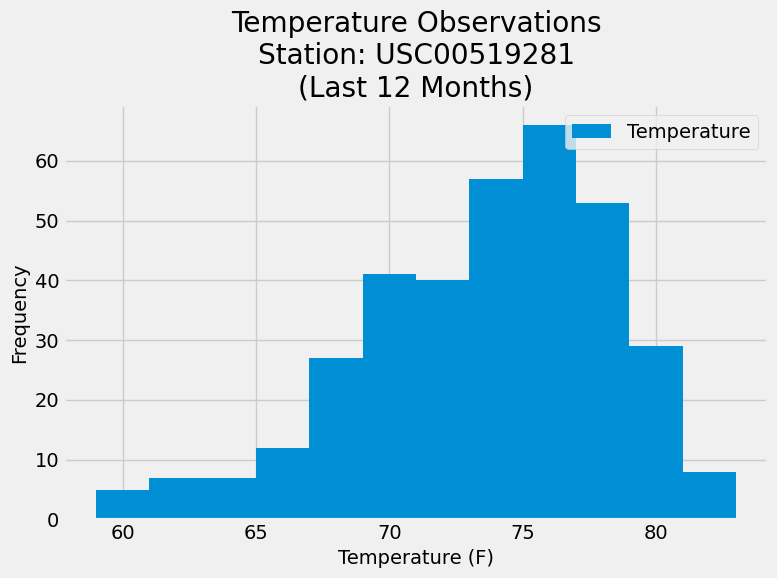

In [46]:
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()
temperatures = [temp[0] for temp in temperature_data]
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, label='Temperature')
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations\nStation: {most_active_station_id}\n(Last 12 Months)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Close Session

In [47]:
# Close Session
session.close()